# One-Hot Encoding, SMC, A workflow
In this document, we calculated Morgan Fingerprint for each reaction in SMC dataset, and then train them use Random forest, Linear Regression, XGBoost & neural network.

In [34]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem

['Cl', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'O', 'C', ')', 'C', '=', 'C', '1', '.', 'O', 'B', '(', 'O', ')', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', '>>', 'C', 'O', 'C', '(', 'C', '=', 'C', '1', ')', '=', 'C', 'C', '=', 'C', '1', 'C', '2', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '2']


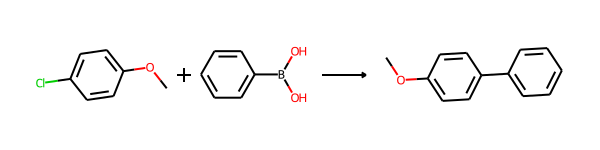

In [35]:
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

smiles_tokenizer = get_default_tokenizer()

reaction_smiles = 'ClC1=CC=C(OC)C=C1.OB(O)C1=CC=CC=C1>>COC(C=C1)=CC=C1C2=CC=CC=C2'
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles,useSmiles=True)

print(smiles_tokenizer.tokenize(reaction_smiles))
rxn

In [36]:
""""
def canonicalize_with_dict(smi, can_smi_dict={}):
    if smi not in can_smi_dict.keys():
        return Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    else:
        return can_smi_dict[smi]
"""
    
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    
    #ligand_smiles_dict = {}
    rxns = []
    """
    The rxns is not useful now. When we use the whole rxn instead of ligand to predict, it will be convenient.
    To try with the entire rxn, tabulate all chemicals into a single column of dataframe.
    """
    smiles = df['Smiles']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns
   

# One-Hot Encoding SMC dataset

In [42]:
# Splitting data
import pandas as pd
from rdkit import Chem
#from rxn_yields.data import generate_buchwald_hartwig_rxns
#df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df_prep = pd.read_excel('smc_data.xlsx', sheet_name='SMC')
df = pd.DataFrame()
df['text']= df_prep['Smiles']
df['Output'] = df_prep['II']

In [45]:
train_df = df.iloc[:71][['text', 'Output']] 
valid_df = df.iloc[71:81][['text', 'Output']] 
test_df = df.iloc[81:][['text', 'Output']] #

train_df.columns = ['text', 'labels']
valid_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']
mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
valid_df['labels'] = (valid_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std
train_df.head()

,text,labels
0,CN(C)C(C=CC=C1N(C)C)=C1C2=CC=CC=C2P(C3CCCCC3)C...,-0.819199
1,C1CCC(CC1)P(C2CCCCC2)c3ccccc3-c4ccccc4,1.602687
2,C1C2CC3CC1CC(P(C14CC5CC(CC(C5)C1)C4)C14CC5CC(C...,-0.857041
3,CC(C)(C)P(C(C)(C)C)C(C)(C)C,-0.857041
4,CCCCP(C12CC3CC(CC(C3)C1)C2)C12CC3CC(CC(C3)C1)C2,-0.592147


In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

enc = preprocessing.OneHotEncoder(sparse=False)
train_df_enc = enc.fit_transform(df)
valid_df_enc = enc.fit_transform(valid_df)
test_df_enc = enc.fit_transform(test_df)
print(train_df_enc.shape)
print(valid_df_enc.shape)

(90, 130)
(10, 17)


# Cleaning up the SMC dataset
Train set: 0-71, validation set: 71-81, test set: 81-all

In [19]:
X_train = train_df_enc.tolist()
y_train = train_df['labels'].tolist()

X_valid = valid_df_enc.tolist()
y_valid = valid_df['labels'].tolist()

X_test = test_df_enc.tolist()
y_test = test_df['labels'].tolist()


In [25]:
print(y_train[0], type(y_train[0]))
print(X_test)

-0.819198558638564 <class 'float'>
[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]]


# Random Forest Model

In [21]:
from sklearn.ensemble import RandomForestRegressor

RF_clf = RandomForestRegressor(max_features=0.8,min_impurity_decrease=0,min_samples_leaf=1,n_estimators=500)
RF_clf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.8, min_impurity_decrease=0,
                      n_estimators=500)

In [ ]:
from sklearn.metrics import mean_squared_error
forest_predictions = RF_clf.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Training set RMSE:",forest_rmse)

forest_predictions2 = RF_clf.predict(X_test)
forest_mse2 = mean_squared_error(y_test, forest_predictions2)
forest_rmse2 = np.sqrt(forest_mse2)
print("Test set RMSE:",forest_rmse2)


In [ ]:
from sklearn.metrics import r2_score
r2_score2=r2_score(y_train, forest_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(y_test, forest_predictions2)
print("Test set R^2:",r2_score3)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
reg_predictions = reg.predict(X_train)
reg_mse = mean_squared_error(y_train, reg_predictions)
reg_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

reg_predictions2 = reg.predict(X_test)
reg_mse2 = mean_squared_error(y_test, reg_predictions2)
reg_rmse2 = np.sqrt(reg_mse2)
print("Test set RMSE:",reg_rmse2)


regr2_score2=r2_score(y_train, reg_predictions)
print("Training set R^2:",regr2_score2)
regr2_score3=r2_score(y_test, reg_predictions2)
print("Test set R^2:",regr2_score3)

# XG Boost

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
xgb_predictions = xgb_model.predict(X_train)
xgb_mse = mean_squared_error(y_train, xgb_predictions)
xgb_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

xgb_predictions2 = xgb_model.predict(X_test)
xgb_mse2 = mean_squared_error(y_test, xgb_predictions2)
xgb_rmse2 = np.sqrt(xgb_mse2)
print("Test set RMSE:",xgb_rmse2)


xgbr2_score2=r2_score(y_train, xgb_predictions)
print("Training set R^2:",xgbr2_score2)
xgbr2_score3=r2_score(y_test, xgb_predictions2)
print("Test set R^2:",xgbr2_score3)

# NN model

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch
class Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size=1024, hidden_size=2048, out_size=1, n_hidden=0, activation=F.relu, bn=False,
                **kwargs):
        super().__init__()
        self.bn = bn
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.hiddens = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(n_hidden)])
        self.bn_hiddens = nn.ModuleList([nn.BatchNorm1d(hidden_size) for i in range(n_hidden)])
        self.bn = nn.BatchNorm1d(hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        self.activation = activation
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        for l, bn in zip(self.hiddens, self.bn_hiddens):
            if self.bn:
                out = bn(out)
            out = self.activation(out)
            out = l(out)
        # Apply activation function
        if self.bn:
            out = self.bn(out)
        out = self.activation(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out.view(-1)   
    
    def training_step(self, batch):
        images, labels = batch 
        #print(images.dtype, labels.dtype)
        out = self(images).view(-1)  
        #print(out.dtype)# Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images).view(-1)                       # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss           # Calculate accuracy
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

In [ ]:
default_nn = Model()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

x_train, y_train, X_valid, y_valid, x_test, y_test = map(
    torch.tensor, (X_train, y_train, X_valid, y_valid, X_test, y_test)
)


training_data = TensorDataset(x_train.to(torch.float32), y_train)
validation_data = TensorDataset(X_valid.to(torch.float32), y_valid)
test_data = TensorDataset(x_test.to(torch.float32), y_test)

batch_size = 128

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for X, y in train_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

In [ ]:
import copy
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5)
    best_loss = np.inf
    best_model = None
    for epoch in range(epochs):
        # Training Phase 
        train_loss = 0.
        train_count = 0
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()*len(batch)
            train_count += len(batch)
        train_loss /= train_count
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = train_loss
        scheduler.step(result["val_loss"])
        
        if result["val_loss"] < best_loss:
            best_model = copy.deepcopy(model)
        
        if epoch%20 == 0:
            model.epoch_end(epoch, result)
        history.append(result)
    return history, best_model

In [ ]:
default_nn = default_nn

In [ ]:
default_nn = Model().to(device)
history, best_model = fit(150, 0.0005, default_nn, train_loader, valid_loader)

In [ ]:
from sklearn.metrics import mean_squared_error
print("train RMSE: ", mean_squared_error(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy()))
print("test RMSE: ", mean_squared_error(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy()))

In [ ]:
from sklearn.metrics import r2_score
r2_score5=r2_score(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy())
print("Training set R^2:",r2_score5)
r2_score6=r2_score(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy())
print("test set R^2:",r2_score6)

In [ ]:
def train_curve(history):
    for key in ["train_loss", "val_loss"]:
        plt.plot([history_[key] for history_ in history], label=key)
    plt.xlabel("epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

In [ ]:
train_curve(history)

# Summary
#### Random Forest:
Training set RMSE: 0.0979

Test set RMSE: 0.269

Training set R^2: 0.990

Test set R^2: 0.930


#### Neural Network:
Training set RMSE: 0.0895

Test set RMSE: 0.136

Training set R^2: 0.911

Test set R^2: 0.868